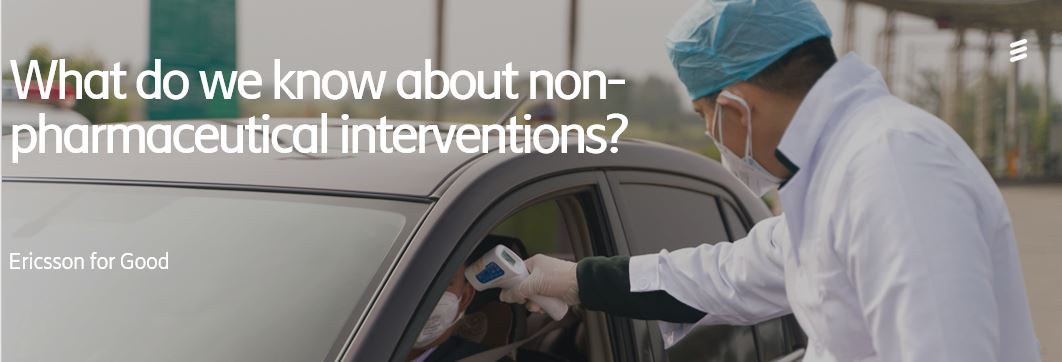


### The goal of this task to summarize the effectiveness of non-pharmaceutical interventions based on the available literature. Further details are requested on the equity and barriers to compliance for these interventions.
<br />
<br />
As of this writing no cure exists for Covid19. The only clinically available prevention measures are non-pharmaceutical in nature. This task is further broken into sub-tasks which relate to:

1. Guidance on ways to scale up NPIs in a more coordinated way (e.g., establish funding, infrastructure and authorities to support real time, authoritative (qualified participants) collaboration with all states to gain consensus on consistent guidance and to mobilize resources to geographic areas where critical shortfalls are identified) to give us time to enhance our health care delivery system capacity to respond to an increase in cases.
<br />
<br />
2. Rapid design and execution of experiments to examine and compare NPIs currently being implemented. DHS Centers for Excellence could potentially be leveraged to conduct these experiments.
<br />
<br />
3. Rapid assessment of the likely efficacy of school closures, travel bans, bans on mass gatherings of various sizes, and other social distancing approaches.
<br />
<br />
4. Methods to control the spread in communities, barriers to compliance and how these vary among different populations.
<br />
<br />
5. Models of potential interventions to predict costs and benefits that take account of such factors as race, income, disability, age, geographic location, immigration status, housing status, employment status, and health insurance status.
<br />
<br />
6. Policy changes necessary to enable the compliance of individuals with limited resources and the underserved with NPIs.
<br />
<br />
7. Research on why people fail to comply with public health advice, even if they want to do so (e.g., social or financial costs may be too high).
<br />
<br />
8. Research on the economic impact of this or any pandemic. This would include identifying policy and programmatic alternatives that lessen/mitigate risks to critical government services, food distribution and supplies, access to critical household supplies, and access to health diagnoses, treatment, and needed care, regardless of ability to pay.


The input data set from the CORD-19 challenge includes over 45,000+ digitized articles from the literature related to the corona virus families. This notebook analyzes the entire corpus with Natural Language Processing (NLP) techniques and pre-trained models such as SciBert and SQuADBERT to answer specific sub-tasks as outlined above.
<br />
<br />
A common processing pipeline and modeling approach for the entire task was chosen. A general pre-process data pipeline was adopted from another Ericsson team.

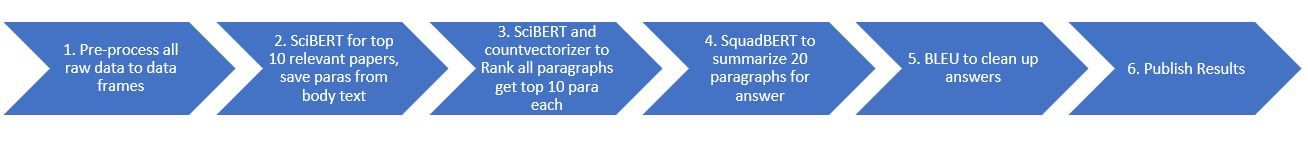

!pip install tqdm
!pip install PrettyTable
!pip install pandas
!pip install nltk
!pip install sentence-transformers

-------

### Import Packages

In [ ]:
!pip install sentence-transformers

In [ ]:
#importing the required libraries
import glob
import json
import logging
import os
import prettytable
import pickle
import re
import shutil
import tqdm
import textwrap
import warnings
import hashlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import plotly.offline as py
import scattertext as st

from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import nltk

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.translate.bleu_score import sentence_bleu

import torch
import tensorflow as tf
import tensorflow_hub as hub

from sentence_transformers import SentenceTransformer
from sentence_transformers import models, SentenceTransformer
from transformers import AutoTokenizer, AutoModel
from transformers import BertForQuestionAnswering, BertTokenizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from absl import logging
from IPython.core.display import display, HTML
from PIL import Image
from tqdm.notebook import tqdm
from ipywidgets import *
from wordcloud import WordCloud

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
warnings.simplefilter('ignore')

print("Packages imported successfully")

In [ ]:
from IPython.core.display import display, HTML 
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_columns', 500)

### Specify Directories

In [ ]:
DATA_PATH = '/kaggle/input/datatask6'
OUTPUT_PATH = '/kaggle/working/'
MODEL_PATH = '/kaggle/input/models/scibert-nli/'

## 1. Download & Pre-Process Raw Data

#### Download Kaggle Data Directly

In [ ]:
# Specify the Kaggle Username and Key to use the Kaggle Api

# os.environ['KAGGLE_USERNAME'] = '*************'
# os.environ['KAGGLE_KEY'] = '****************'

In [ ]:
# from kaggle.api.kaggle_api_extended import KaggleApi

# api = KaggleApi()
# api.authenticate()

# api.dataset_download_files(dataset="allen-institute-for-ai/CORD-19-research-challenge", path=DATA_PATH, unzip=True)

In [ ]:
# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# The raw code for this IPython notebook is by default hidden for easier reading.
# To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

#### Helper Class to Extract Data & Convert it to DataFrame

In [ ]:
# Helper class to extract data and convert it to df
class PaperReader:
    
    # initializing
    def __init__(self, root_path):
        self.root_path = root_path
        self.filenames = glob.glob('{}/**/*.json'.format(root_path), recursive=True)
        print(str(len(self.filenames))+' files were found')
    
    # load files
    def load_files(self):
        raw_files = []

        for filename in tqdm(self.filenames):
            file = json.load(open(filename, 'rb'))
            raw_files.append(file)

        return raw_files
    
    # extract values from keys
    def extract_value(self, key, dictionary):
        
        for k, v in dictionary.items():
            
            if k == key:
                yield v
                break
            elif isinstance(v, dict):
                for result in self.extract_value(key, v):
                    yield result
            elif isinstance(v, list):
                
                for d in v:
                    if type(d) == dict:
                        for result in self.extract_value(key, d):
                            yield result  

    # Function to generate Clean DF
    def generate_clean_df(self):
        
        raw_files = self.load_files()
        cleaned_files = []

        for content in tqdm(raw_files):
            
            # extract paper_id ( sha)
            paper_id = list(self.extract_value('paper_id', content))
            paper_id = paper_id[0]

            if 'metadata' in content.keys():
                # extract title
                title = list(self.extract_value('metadata', content)) 
                title = title[0]['title']
#             else:
#                 title = np.nan

            # extract abstract
            if 'abstract' in content.keys():
                abstract = list(self.extract_value('abstract', content)) 
                abstract = ' \n\n\n '.join([element['text'] for element in abstract[0] if len(element['text']) > 200 ])
#            else:
#                abstract = np.nan

            # extract body
            if 'body_text' in content.keys():
                body = list(self.extract_value('body_text', content)) 
                body = ' \n\n\n '.join([element['section'] + ' \n ' + element['text'] for element in body[0] if len(element['text']) > 200])
#             else:
#                 body = np.nan

            # extract bib_entries
            if 'bib_entries' in content.keys():
                bib_entries = list(self.extract_value('bib_entries', content)) 
                bib = []
                for edx, el in enumerate(bib_entries[0]):
                    #index = bib_entries[0][el]['ref_id']
                    bib_title = bib_entries[0][el]['title']
                    bib.append(bib_title)

                bib = ' \n\n'.join(bib)
#             else:
#                 bib = np.nan

            # extract red entries
            if 'ref_entries' in content.keys():
                ref_entry = list(self.extract_value("ref_entries",  content)) 
                ref_ent = []
                for rdx, re in enumerate(ref_entry[0]): 
                    #print(re)
                    #print(ref_entry[0][re])
                    ref_ent.append(ref_entry[0][re]['type'] + ' \n ' + ref_entry[0][re]['text'] )
                ref_entry = ' \n\n\n '.join(ref_ent)
#             else:
#                 ref_entry = np.nan

            # extract back matter
            if 'back_matter' in content.keys():
                back_matter = list(self.extract_value("back_matter", content)) 
                back_matter = ' \n\n\n '.join([element['section'] + ' \n ' + element['text'] for element in back_matter[0]])
#             else:
#                 back_matter = np.nan

            # create a dataframe of extracted json file
            file_dataframe = pd.DataFrame.from_dict({   'paper_id': [paper_id], 
                                            'title': [title],
                                            'abstract': [abstract],
                                            'text' : [body],
                                            'bib_entries': [bib],
                                            'ref_entries': [ref_entry],
                                            'back_matter': [back_matter]
                                        })

            # append file_dataframe to file_paths_df list
            cleaned_files.append(file_dataframe)
        
        # concat all the dataframes present in file_paths_df list         
        data = pd.concat(cleaned_files)
        
        # reset index of data dataframe
        data.reset_index(inplace = True, drop = True)
        
        return data

In [ ]:
#PR = PaperReader(INPUT_PATH)

In [ ]:
# generate Dataframe
#papers_df = PR.generate_clean_df()
#papers_df.head()

In [ ]:
# save extracted data
# papers_df.to_excel(DATA_PATH + 'extracted_data.xlsx', index = False)

In [ ]:
# helper function to locate the json files
def find_file(filename):
    result = []
    for root, dir, files in os.walk(DATA_PATH):
        if filename in files:
            result.append(os.path.join(root, filename))
    return result[0]

### Questions from task 6

In [ ]:
task_questions = ["Guidance on ways to scale up NPIs in a more coordinated way (e.g., establish funding, infrastructure and authorities to support real time, authoritative (qualified participants) collaboration with all states to gain consensus on consistent guidance and to mobilize resources to geographic areas where critical shortfalls are identified) to give us time to enhance our health care delivery system capacity to respond to an increase in cases.",
            "Rapid design and execution of experiments to examine and compare NPIs currently being implemented. DHS Centers for Excellence could potentially be leveraged to conduct these experiments.",
            "Rapid assessment of the likely efficacy of school closures, travel bans, bans on mass gatherings of various sizes, and other social distancing approaches.",
            "Methods to control the spread in communities, barriers to compliance and how these vary among different populations",
            "Models of potential interventions to predict costs and benefits that take account of such factors as race, income, disability, age, geographic location, immigration status, housing status, employment status, and health insurance status.",
            "Policy changes necessary to enable the compliance of individuals with limited resources and the underserved with NPIs.",
            "Research on why people fail to comply with public health advice, even if they want to do so (e.g., social or financial costs may be too high).",
            "Research on the economic impact of this or any pandemic. This would include identifying policy and programmatic alternatives that lessen/mitigate risks to critical government services, food distribution and supplies, access to critical household supplies, and access to health diagnoses, treatment, and needed care, regardless of ability to pay."]

#### Simplify the questions, Attention based BERT relies on clear question

In [ ]:
questions = ["How to scale up Non Pharmaceutical Interventions for COVID-19 ?",
            "What are the methods to compare Non Pharmaceutical Interventions for COVID-19 ?",
            "What are the effect of travel bans for COVID-19 ?",
            "What are the methods to control the community spread for COVID-19 ?",
            "What are the Non Pharmaceutical Interventions models to predict costs and benefits for COVID-19 ?",
            "What are the required policy changes to enable the compliance of individuals with limited resources for COVID-19 ?",
            "Why people fail to comply with public health advice for COVID-19 ?",
            "What is the economic impact of pandemic ?"]

## >>> In this example the first question is picked <<<

The model was previously run against several simplified questions for each sub-task
### using SciBERT to get top 10 papers, save body text in to one list

In [ ]:
question = questions[2]
print(f"This is the question you are looking at: ")
print(f"  ==>   {question}")

### Load uncleaned data, as SciBERT needs dot to see the whole sentence, so stop_words just makes it worse

In [ ]:
papers_df = pd.read_excel(DATA_PATH + '/extracted_data.xlsx')

In [ ]:
papers_df.columns

In [ ]:
papers_df.head()

In [ ]:
papers_df.isnull().sum()

### Combine 'Abstract' and 'Title' as corpus, not embedding whole body_text

It takes a lot of time to create embeddings for whole body of the article. Furthermore, since there are missing values in 'Abstract' and "title" why we decided to use combination of "asbtract" and "title". Our first Priority is "abstract" as it contains more information than the "title" and then use "title" wherever "abstract" is missing. 

In [ ]:
papers_df['Embedding_Col'] = papers_df['abstract'].copy(deep= True)
papers_df.head()

In [ ]:
# creating mask where "abstract" is missing
abs_mask = papers_df['Embedding_Col'].isna()
#abs_mask

In [ ]:
# copy title to Embdding_Col where abstract is missing
papers_df['Embedding_Col'][abs_mask] = papers_df['title'][abs_mask].copy(deep = True)

In [ ]:
# create mask for not null values in Embdding_Col column 
abs_sec_mask = papers_df['Embedding_Col'].notna()
abs_sec_mask.value_counts()

In [ ]:
working_Data = papers_df[abs_sec_mask].copy(deep = True)

In [ ]:
working_Data.isnull().sum()

In [ ]:
# Model Training part

# if not os.path.isdir(MODEL_PATH+'SciBERT-NLI Pretrained/):
#     os.mkdir(MODEL_PATH+'SciBERT-NLI Pretrained/)
# else:
#     pass


# tokenizer = AutoTokenizer.from_pretrained("gsarti/scibert-nli")

# model = AutoModel.from_pretrained("gsarti/scibert-nli")

# model.save_pretrained(MODEL_PATH+'SciBERT-NLI Pretrained/)

# tokenizer.save_pretrained(MODEL_PATH+'SciBERT-NLI Pretrained/)
# word_embedding_model = models.BERT(MODEL_PATH+'SciBERT-NLI Pretrained/)

# pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),

#                        pooling_mode_mean_tokens=True,

#                        pooling_mode_cls_token=False,

#                        pooling_mode_max_tokens=False)

# model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

# shutil.rmtree(MODEL_PATH+'SciBERT-NLI Pretrained/)

# model.save(MODEL_PATH+'SciBERT-NLI Pretrained/)

### Encode the Embedding_Col

In [ ]:
# load the scibert-nli model
sciBert_model = SentenceTransformer(MODEL_PATH)

In [ ]:
# remove duplicate values 
working_Data.drop_duplicates(['Embedding_Col'], keep='first', inplace=True)

In [ ]:
metadata_df = pd.read_csv(DATA_PATH + '/metadata.csv')

In [ ]:
metadata_df.rename(columns={'sha': 'paper_id'}, inplace=True)

In [ ]:
merged_data = pd.merge(working_Data, 
                       metadata_df[['paper_id','cord_uid', 'source_x', 'publish_time', 'url']], 
                      on = 'paper_id', 
                       how='left')

In [ ]:
merged_data.head()

In [ ]:
str_mask = merged_data['Embedding_Col'].str.contains('2019-nCoV')

In [ ]:
merged_data['Embedding_Col'][str_mask]  = merged_data['Embedding_Col'][str_mask].str.replace('2019-nCoV', 'covid-19')

In [ ]:
merged_data.drop_duplicates(['Embedding_Col'], keep='first', inplace=True)

In [ ]:
# merged_data.to_excel(DATA_PATH + '/merged_data.xlsx', index = False)

In [ ]:
# merged_data = pd.read_excel(DATA_PATH + '/merged_data.xlsx')

In [ ]:
merged_data['Embedding_Col'] = merged_data['Embedding_Col'].str.strip()

In [ ]:
corpus = [re.sub(' \n\n\n ','',x) for x in merged_data['Embedding_Col'].to_list()]

## 2. SciBERT to get top 10 relevant paper, save all paragraphs from body text

In [ ]:
# create embedding for the text in Embdding_Col column 
# fulldfembedding = sciBert_model.encode(corpus, show_progress_bar=True)

### save embeddings to pickle file so can be loaded later to avoid re-embedding

In [ ]:
# with open(DATA_PATH + '/Abstract_Title_embd.pkl', 'wb') as emb:
#     pickle.dump(fulldfembedding, emb)

In [ ]:
# load pickled file of embeddings
with open(DATA_PATH + '/Abstract_Title_embd.pkl', 'rb') as emb:
    fulldfembedding = pickle.load(emb)

In [ ]:
def ask_question(query, model, corpus, corpus_embed, top_k=20):
    """
    Adapted from https://www.kaggle.com/dattaraj/risks-of-covid-19-ai-driven-q-a
    """
    queries = [query]
    query_embeds = model.encode(queries, show_progress_bar=False)
    for query, query_embed in zip(queries, query_embeds):
        distances = scipy.spatial.distance.cdist([query_embed], corpus_embed, "cosine")[0]
        distances = zip(range(len(distances)), distances)
        distances = sorted(distances, key=lambda x: x[1])
        results = []
        for count, (idx, distance) in enumerate(distances[0:top_k]):
            results.append([count + 1, idx, corpus[idx], round(1 - distance, 4)])
    return results


def show_answers(results):
    table = prettytable.PrettyTable(
        ['Rank', 'S.No.', 'Embedding Column', 'Score']
    )
    for res in results:
        rank = res[0]
        sno = res[1]
        text = res[2]
        text = textwrap.fill(text, width=75)
        text = text + '\n\n'
        score = res[3]
        table.add_row([
            rank,
            sno,
            text,
            score
        ])
    print('\n')
    print(str(table))
    print('\n')

In [ ]:
# get the results from the question 3 -> "What are the effect of travel bans for COVID-19 ?"
question = questions[2]
results = ask_question(question, sciBert_model, corpus, fulldfembedding)
#results
#question

In [ ]:
#@supress_stdout
def hash_results(results, merged_data):
    hashed_paras = []
    context = []
    para_from_paperid = {}
    para_from_papertitle = {}
    para_from_paperurl = {}

    for result in results:
        index = result[1]
        paper_title = merged_data['title'].iloc[index]
        #print(f"result: {paper_title}")
        paper_sha = merged_data['paper_id'].iloc[index]
        paper_cord_uid = merged_data['cord_uid'].iloc[index]
        paper_url = merged_data['url'].iloc[index]
        #print(f"type of paper_sha is: {type(paper_sha)} paper_sha is: {paper_sha}")
        body = merged_data['text'].iloc[index]
        if isinstance(body, str):
            for para in body.split(' \n\n\n '):
                mystring = para.replace('\n', '')

                context.append(mystring)
                #mystring = 'b' + "'" +mystring
                # Assumes the default UTF-8
                hash_object = hashlib.sha256(mystring.encode("utf-8"))
                hex_dig = hash_object.hexdigest()
                hashed_paras.append(hex_dig)
                para_from_paperid[hex_dig] = merged_data['paper_id'].iloc[1306]
                para_from_papertitle[hex_dig] = paper_title
                para_from_paperurl[hex_dig] = paper_url
    
    return hashed_paras,context, para_from_paperid,para_from_papertitle, para_from_paperurl    

In [ ]:
hashed_paras,context, para_from_paperid,para_from_papertitle, para_from_paperurl = hash_results(results, merged_data)

In [ ]:
show_answers(results)

print(f"above paragraph is from paper cord_uid: {para_from_paperid[context[100]]}")

In [ ]:
context_list = [x for x in context if len(x) > 150]

## 3. SciBERT and countvectorizer to Rank all paragraphs to get top 10 paragraphs each

### SciBERT to obtain top 10 paragraphs

In [ ]:
def find_top_para_bert(context, question):
    # create embeddings for paragraphs 
    para_embeddings = sciBert_model.encode(context, show_progress_bar=True)
    # create embeddings for question 
    query_embed = sciBert_model.encode(question, show_progress_bar=True)
    for query, query_emb in zip(question, query_embed):
        distances = cdist([query_emb], para_embeddings, "cosine")[0]
        distances = zip(range(len(distances)), distances)
        distances = sorted(distances, key=lambda x: x[1])
        results = []
        for count, (idx, distance) in enumerate(distances[0:10]):
            results.append([count+1, idx, context[idx], round(1 - distance, 4) ])
    return results
    

In [ ]:
top_para_bert = find_top_para_bert(context_list, question)
show_answers(top_para_bert)

### Rank Paragraphs using CountVectorizer Approach to obtain 10 more paragraphs

In [ ]:
def find_top_para_CVect(context, question):
    para_list = context
    #tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    count_vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 2))
    count_vec_total_text = count_vectorizer.fit_transform(para_list)
    count_vec_question = count_vectorizer.transform([question])
    distance_array = cosine_similarity(count_vec_question, count_vec_total_text)
    distance_array = distance_array[0]
    
    top_n = 10
    top_passages = []
    for index in distance_array.argsort()[::-1][:top_n]:
        #print(index, ' ', para_list[index])
        #print('-' * 120)
        top_passages.append((index, para_list[index]))
    return top_passages

In [ ]:
top_para_CVec = find_top_para_CVect(context_list, question)

In [ ]:
for index, para in top_para_CVec:
    print(index, para)
    print('-' * 120)

## 4. SQUAD BERT to summarize 20 paragraphs to give answer.
### Why SQuADBERT?
Ready to use off the shelf models and easy to maintain. BERT is a multi-layer bidirectional transformer encoder based on the original implementation in Vaswani etal in 2017
Stanford Question Answering Dataset (SQuAD) is a reading comprehension dataset, consisting of questions on a set of Wikipedia articles, where the answer to every question is a segment of text, or span, from the corresponding reading passage, or the question might be unanswerable. We used SQuADBERT on the shortlisted articles from previous steps.

### 10 paragraphs from SciBERT and 10 more paragraphs from CountVectorizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
squad_model = BertForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")

In [ ]:
def squad_bert_results(top_para_bert, top_para_CVec):
    cv_indexes = [i[0] for i in top_para_CVec ]
    scibert_indexes = [x[1] for x in top_para_bert]
    indices  = set(cv_indexes + scibert_indexes )
    countVec_para_list = [x[1].replace(' \n ', ' ') for x in top_para_CVec if x[0] in indices ]
    sciBert_para_list = [x[2].replace(' \n ', ' ') for x in top_para_bert if x[1] in indices]
    all_paras = countVec_para_list + sciBert_para_list
    predicted_answer_list = []
    predicted_passage_list = []
    results = {}
    for padx, passage in enumerate(all_paras):
        inputs = tokenizer.encode_plus(question, passage, add_special_tokens=True, return_tensors="pt",max_length=512)
        input_ids = inputs["input_ids"].tolist()[0]

        text_tokens = tokenizer.convert_ids_to_tokens(input_ids)
        answer_start_scores, answer_end_scores = squad_model(**inputs)

        answer_start = torch.argmax(answer_start_scores)  # Get the most likely beginning of answer with the argmax of the score
        answer_end = torch.argmax(answer_end_scores) + 1  # Get the most likely end of answer with the argmax of the score

        answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))

        Flag = False
        hash_object = hashlib.sha256(passage.encode("utf-8"))
        hex_dig = hash_object.hexdigest()
        results[padx] = [question, answer,passage, para_from_paperid[hex_dig], para_from_papertitle[hex_dig], para_from_paperurl[hex_dig] ]
        if len(answer) >10 and '[CLS]' not in answer and '[SEP]' not in answer :
            predicted_answer_list.append([padx, answer])
            Flag = True
            hash_object = hashlib.sha256(passage.encode("utf-8"))
            hex_dig = hash_object.hexdigest()
            results[padx] = [Flag, question, answer,passage, para_from_paperid[hex_dig], para_from_papertitle[hex_dig], para_from_paperurl[hex_dig] ]
            predicted_passage_list.append(passage)
            """
            print(f"==============================================================")
            print(f"QUESTION: {question}")
            print(f"--------------------------------------------------------------")
            print(f"ANSWER: {answer}\n")
            print(f"this is from paragraph: ")
            print(passage)
            print(f"^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
            print(f"paper cord_uid: {para_from_paperid[hex_dig]}")
            print(f"paper title: {para_from_papertitle[hex_dig]}")
            print(f"paper url: {para_from_paperurl[hex_dig]}")
            print(f"==============================================================")  
            """
    return results, predicted_answer_list

In [ ]:
squad_results, predicted_answer_list = squad_bert_results(top_para_bert, top_para_CVec)

In [ ]:
predicted_answer_list

## 5. BLEU score to validate and clean up answers
### Post processing approaches: 
We tried Cosine similarity and Text summarization approaches. However, we found the results from BLEU (bilingual evaluation understudy) Score are better. BLUE is a metric for evaluating a generated sentence to a reference sentence. In our context, we used to compare the results from each answer to all other answers in the ranking order and consolidate the results. 2-grams option worked best for our scenarios. 
We pass the results from BLUE to another post-processing technique, Semantic Similarity with TF-Hub Universal Encoder. 


In [ ]:
def bleu_post_process(predicted_answer_list):
    predicted_answer = predicted_answer_list
    
    bleu_matrix = np.zeros((len(predicted_answer),len(predicted_answer)))
    for idx, i in enumerate(predicted_answer):
        for jdx,j in enumerate(predicted_answer):
            if idx != jdx:
                reference = [word_tokenize(predicted_answer[idx][1])]
                candidate = word_tokenize(predicted_answer[jdx][1])
                bleu_matrix[idx,jdx] = sentence_bleu(reference, candidate, weights=(0, 1, 0, 0))   
            elif idx == jdx:
                bleu_matrix[idx,jdx] = 1
    twoGram=pd.DataFrame(bleu_matrix)
    elements =[]

    elements2remove = []

    for row in range(0,len(twoGram)):
        elements.append([row,twoGram.iloc[row][(twoGram.iloc[row] >=0.001) & (twoGram.iloc[row] != 1)].index])

    for pdx, p in enumerate(elements):
        if len(p[1]) >0 :
            for item in p[1]:
                if item > pdx:
                    elements2remove.append(item)
                    
    remove_indices = list(set(elements2remove))
    
    Processed_answers = [[j,i] for j, i in enumerate(predicted_answer) if j not in remove_indices]
    
    return twoGram, Processed_answers

twoGram, Processed_answers =bleu_post_process(predicted_answer_list)

cm = sns.light_palette("blue", as_cmap=True)
#twoGram=pd.DataFrame(bleu_matrix)
print('\n')
print("2-Gram BLEU Score Matrix")
twoGram_Style=twoGram.style.background_gradient(cmap=cm)
display(twoGram_Style)

In [ ]:
for pdx, p in enumerate(Processed_answers):
    print(f"==============================================================")
    print(f"QUESTION: {squad_results[p[1][0]][1]}")
    print(f"--------------------------------------------------------------")
    print(f"ANSWER: {squad_results[p[1][0]][2]}\n")
    print(f"this is from paragraph: ")
    print(squad_results[p[1][0]][3])
    print(f"^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
    print(f"paper cord_uid: {squad_results[p[1][0]][4]}")
    print(f"paper title: {squad_results[p[1][0]][5]}")
    print(f"paper url: {squad_results[p[1][0]][6]}")
    print(f"==============================================================")  
    


In [ ]:
solutions = {}
for qdx, question in enumerate(questions):
    results = ask_question(question, sciBert_model, corpus, fulldfembedding)
    hashed_paras,context, para_from_paperid,para_from_papertitle, para_from_paperurl = hash_results(results, merged_data)
    top_para_bert = find_top_para_bert(context, question)
    top_para_CVec = find_top_para_CVect(context, question)
    squad_results, predicted_answer_list = squad_bert_results(top_para_bert, top_para_CVec)
    twoGram, Processed_answers =bleu_post_process(predicted_answer_list)
    df_list = []
    for pdx, p in enumerate(Processed_answers):
        df = pd.DataFrame({'QUESTION': [squad_results[p[1][0]][1]],    
                            'paper cord_uid': [squad_results[p[1][0]][4]],
                            'paper title': [squad_results[p[1][0]][5]],
                            'paper url': [squad_results[p[1][0]][6]],
                              'Short Answer ': [squad_results[p[1][0]][2]],
                                'Relevant Paragraph' :[squad_results[p[1][0]][3]]})
        df_list.append(df)
    frame = pd.concat(df_list)
    frame.reset_index(inplace=True)
    frame.drop(['index'], inplace = True, axis = 1)
    solutions[qdx+1]=frame 

In [ ]:
final_list = [solutions[keys] for keys in solutions.keys()]
final_df = pd.concat(final_list)
final_df.reset_index(inplace=True)
final_df.drop(['index'], inplace = True, axis = 1)
final_df.head()
#final_df.head().style.set_properties(subset=['Relevant Paragraph'], **{'width': '300px'})

In [ ]:
!jupyter nbextension enable --py widgetsnbextension

In [ ]:
import ipywidgets as widgets
#from ipywidgets import interactive
from IPython.display import display
from IPython.html.widgets import interactive 
items = ['All']+sorted(final_df['QUESTION'].unique().tolist())
 
def view(Question=''):
    if Question=='All': display(final_df)
    display(final_df[final_df['QUESTION']==Question])
    
def question_ask(question, sciBert_model, merged_data, fulldfembedding):
    corpus = [re.sub(' \n\n\n ','',x) for x in merged_data['Embedding_Col'].to_list()]
    results = ask_question(question, sciBert_model, corpus, fulldfembedding)
    hashed_paras,context, para_from_paperid,para_from_papertitle, para_from_paperurl = hash_results(results, merged_data)
    top_para_bert = find_top_para_bert(context, question)
    top_para_CVec = find_top_para_CVect(context, question)
    squad_results, predicted_answer_list = squad_bert_results(top_para_bert, top_para_CVec)
    twoGram, Processed_answers =bleu_post_process(predicted_answer_list)
    df_list = []
    for pdx, p in enumerate(Processed_answers):
        df = pd.DataFrame({'QUESTION': [squad_results[p[1][0]][1]],    
                            'paper cord_uid': [squad_results[p[1][0]][4]],
                            'paper title': [squad_results[p[1][0]][5]],
                            'paper url': [squad_results[p[1][0]][6]],
                              'Short Answer ': [squad_results[p[1][0]][2]],
                                'Relevant Paragraph' :[squad_results[p[1][0]][3]]})
        df_list.append(df)
    frame = pd.concat(df_list)
    frame.reset_index(inplace=True)
    frame.drop(['index'], inplace = True, axis = 1)
    return frame
 
w = widgets.Dropdown(options=items)
q = widgets.Text(value='question')
#interactive(view, Question=w)

In [ ]:
#create tabs
tab_nest = widgets.Tab()
# tab_nest.children = [tab_visualise]
tab_nest.set_title(0, 'Results')
#tab_nest.set_title(1, 'Ask Question')


#interact function in isolation
f = interactive(view, Question=w);
#f1 = interactive(question_ask, sciBert_model=sciBert_model, merged_data=merged_data, fulldfembedding=fulldfembedding, question=q);
tab_nest.children = [VBox(children = f.children) ]
display(tab_nest)

## User Based Question

In [ ]:
#question = input('Enter Question: ')
#question_ask(question, sciBert_model, merged_data, fulldfembedding)

### Semantic Textual Similarity using universal sentence encoder

Post Processing from BELU score removed substantial irrelevant results w.r.t. the questions. However, there some of the reults were still not acceptable. In order to extract more relevant answers, we pipelined the relevant results from BLEU score analysis to create emeddings using Universal Sentence Encoder. We generated heatmap from the similarity score of the embeddings. From the heatmap we can see two clusters of the senteces: one having highly similar and other having very less similairty. 

In [ ]:
#@title Load the Universal Sentence Encoder's TF Hub module

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
    return model(input)

In [ ]:
def plot_similarity(labels, features, rotation):
    corr = np.inner(features, features)
    sns.set(font_scale=0.8)
    g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
    message_embeddings_ = embed(messages_)
    plot_similarity([textwrap.fill(x)[:100] for x in messages_], message_embeddings_, 90)

In [ ]:
# showing only first 100 leters in the labels
l = [x[1][1] for x in Processed_answers]

#np.inner(embed(l), embed(l))
run_and_plot(l)

In [ ]:
final_df.head()

In [ ]:
## Excel Results reading to Pandas
#****### The following code lets the reader view the most relevant answers in the already run results. The excel file is organized in tabs 6.1, 6.2, 6.3... 6.8, corresponding to each sub-task. The result for each sub-task can be passed by the corresponding sheet name to the code below.
### Note the display is limited up to top 5 results, a complete set of paper results is captured in the attached excel
#References: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html
# import pandas as pd

# df = pd.read_excel (r'Task6 Results and Analysis_final.xlsx', sheet_name='6.3')
# pd.set_option('display.max_colwidth', None)
# df.head()

## Visulaizations

In [ ]:
predicted_list = [y[1] for y in predicted_answer_list]
#predicted_list

In [ ]:
def gen_wordcloud(passage_list, ericsson_style=False):
    '''
    i/p: a list of passages: list[str]
    o/p: None, plots the picture
    '''
    all_passages = ' '.join(predicted_list)
    
    stopwords = set(STOPWORDS)
    
    if ericsson_style:
        mask = np.array(Image.open('/kaggle/input/ericssonlogo/ericsson-logo-clipart.jpg'))

        wordcloud = WordCloud(stopwords=stopwords, background_color="white", mode="RGBA", max_words=1000, mask=mask).generate(all_passages)

        # create coloring from image
        image_colors = ImageColorGenerator(mask)
        plt.figure(figsize=[18,10])
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
        plt.axis("off")
        plt.show()

    else:
        wordcloud = WordCloud().generate(all_passages)

        wordcloud = WordCloud(max_font_size=40).generate(all_passages)
        plt.figure(figsize = (15, 10))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()

In [ ]:
# run this function for a paragraph list of each question
gen_wordcloud(predicted_list)

In [ ]:
#os.listdir('/kaggle/input/ericssonlogo/')

In [ ]:
# gen_wordcloud(predicted_list, ericsson_style=True)

### Packages and licenses
- Os : https://github.com/rancher/os/blob/master/LICENSE
- Tqdm : https://github.com/tqdm/tqdm/blob/master/LICENCE
- Sklearn : https://scikit-learn.org/stable/about.html#citing-scikit-learn
- Transformers : https://github.com/huggingface/transformers/blob/master/LICENSE
- Sentence_Transformers : https://github.com/UKPLab/sentence-transformers/blob/master/LICENSE
- Scibert-nli : https://huggingface.co/gsarti/scibert-nli
- Nltk : https://github.com/nltk/nltk/blob/develop/LICENSE.txt
- Pytorch : https://github.com/pytorch/pytorch/blob/master/LICENSE
- Bert : https://github.com/google-research/bert/blob/master/LICENSE
- Tensorflow : https://github.com/tensorflow/tensorflow/blob/master/LICENSE
- Tensorflow Hub : https://github.com/tensorflow/hub/blob/master/LICENSE

### Team members
1. Evan Bechtol
2. Anders Berkeman
3. Ana Bogic
4. Rafael Carmargo
5. Carlos Gonzalez
6. Arnab Guha
7. Satish Gujar
8. Ilyas Habeeb
9. Paul Lamb
10. Robin Liu
11. Randy McDowell
12. Jody Mitchie
13. Piyush Mittal
14. Roland Smith
15. Sunil Kumar Vuppala


## License Agreements

#### PSF LICENSE AGREEMENT FOR PYTHON 3.8.2
1. This LICENSE AGREEMENT is between the Python Software Foundation ("PSF"), and
   the Individual or Organization ("Licensee") accessing and otherwise using Python
   3.8.2 software in source or binary form and its associated documentation.

2. Subject to the terms and conditions of this License Agreement, PSF hereby
   grants Licensee a nonexclusive, royalty-free, world-wide license to reproduce,
   analyze, test, perform and/or display publicly, prepare derivative works,
   distribute, and otherwise use Python 3.8.2 alone or in any derivative
   version, provided, however, that PSF's License Agreement and PSF's notice of
   copyright, i.e., "Copyright © 2001-2020 Python Software Foundation; All Rights
   Reserved" are retained in Python 3.8.2 alone or in any derivative version
   prepared by Licensee.

3. In the event Licensee prepares a derivative work that is based on or
   incorporates Python 3.8.2 or any part thereof, and wants to make the
   derivative work available to others as provided herein, then Licensee hereby
   agrees to include in any such work a brief summary of the changes made to Python
   3.8.2.

4. PSF is making Python 3.8.2 available to Licensee on an "AS IS" basis.
   PSF MAKES NO REPRESENTATIONS OR WARRANTIES, EXPRESS OR IMPLIED.  BY WAY OF
   EXAMPLE, BUT NOT LIMITATION, PSF MAKES NO AND DISCLAIMS ANY REPRESENTATION OR
   WARRANTY OF MERCHANTABILITY OR FITNESS FOR ANY PARTICULAR PURPOSE OR THAT THE
   USE OF PYTHON 3.8.2 WILL NOT INFRINGE ANY THIRD PARTY RIGHTS.

5. PSF SHALL NOT BE LIABLE TO LICENSEE OR ANY OTHER USERS OF PYTHON 3.8.2
   FOR ANY INCIDENTAL, SPECIAL, OR CONSEQUENTIAL DAMAGES OR LOSS AS A RESULT OF
   MODIFYING, DISTRIBUTING, OR OTHERWISE USING PYTHON 3.8.2, OR ANY DERIVATIVE
   THEREOF, EVEN IF ADVISED OF THE POSSIBILITY THEREOF.

6. This License Agreement will automatically terminate upon a material breach of
   its terms and conditions.

7. Nothing in this License Agreement shall be deemed to create any relationship
   of agency, partnership, or joint venture between PSF and Licensee.  This License
   Agreement does not grant permission to use PSF trademarks or trade name in a
   trademark sense to endorse or promote products or services of Licensee, or any
   third party.

8. By copying, installing or otherwise using Python 3.8.2, Licensee agrees
   to be bound by the terms and conditions of this License Agreement.
 
 
#### The 3-Clause BSD License
 
Note: This license has also been called the "New BSD License" or "Modified BSD License". See also the 2-clause BSD License.

Copyright <YEAR> <COPYRIGHT HOLDER>

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its contributors may be used to endorse or promote products derived from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

#### NumPy license
Copyright © 2005-2020, NumPy Developers.
All rights reserved.
Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.

Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.

Neither the name of the NumPy Developers nor the names of any contributors may be used to endorse or promote products derived from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS “AS IS” AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT OWNER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

 
#### The MIT License
 
Copyright <YEAR> <COPYRIGHT HOLDER>

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

  
#### License agreement for matplotlib versions 1.3.0 and later
=========================================================

1. This LICENSE AGREEMENT is between the Matplotlib Development Team
("MDT"), and the Individual or Organization ("Licensee") accessing and
otherwise using matplotlib software in source or binary form and its
associated documentation.

2. Subject to the terms and conditions of this License Agreement, MDT
hereby grants Licensee a nonexclusive, royalty-free, world-wide license
to reproduce, analyze, test, perform and/or display publicly, prepare
derivative works, distribute, and otherwise use matplotlib
alone or in any derivative version, provided, however, that MDT's
License Agreement and MDT's notice of copyright, i.e., "Copyright (c)
2012- Matplotlib Development Team; All Rights Reserved" are retained in
matplotlib  alone or in any derivative version prepared by
Licensee.

3. In the event Licensee prepares a derivative work that is based on or
incorporates matplotlib or any part thereof, and wants to
make the derivative work available to others as provided herein, then
Licensee hereby agrees to include in any such work a brief summary of
the changes made to matplotlib .

4. MDT is making matplotlib available to Licensee on an "AS
IS" basis.  MDT MAKES NO REPRESENTATIONS OR WARRANTIES, EXPRESS OR
IMPLIED.  BY WAY OF EXAMPLE, BUT NOT LIMITATION, MDT MAKES NO AND
DISCLAIMS ANY REPRESENTATION OR WARRANTY OF MERCHANTABILITY OR FITNESS
FOR ANY PARTICULAR PURPOSE OR THAT THE USE OF MATPLOTLIB
WILL NOT INFRINGE ANY THIRD PARTY RIGHTS.

5. MDT SHALL NOT BE LIABLE TO LICENSEE OR ANY OTHER USERS OF MATPLOTLIB
 FOR ANY INCIDENTAL, SPECIAL, OR CONSEQUENTIAL DAMAGES OR
LOSS AS A RESULT OF MODIFYING, DISTRIBUTING, OR OTHERWISE USING
MATPLOTLIB , OR ANY DERIVATIVE THEREOF, EVEN IF ADVISED OF
THE POSSIBILITY THEREOF.

6. This License Agreement will automatically terminate upon a material
breach of its terms and conditions.

7. Nothing in this License Agreement shall be deemed to create any
relationship of agency, partnership, or joint venture between MDT and
Licensee.  This License Agreement does not grant permission to use MDT
trademarks or trade name in a trademark sense to endorse or promote
products or services of Licensee, or any third party.

8. By copying, installing or otherwise using matplotlib ,
Licensee agrees to be bound by the terms and conditions of this License
Agreement.
 
#### 3-clause license ("BSD License 2.0", "Revised BSD License", "New BSD License", or "Modified BSD License")
Copyright (c) <year>, <copyright holder>
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:
    * Redistributions of source code must retain the above copyright
      notice, this list of conditions and the following disclaimer.
    * Redistributions in binary form must reproduce the above copyright
      notice, this list of conditions and the following disclaimer in the
      documentation and/or other materials provided with the distribution.
    * Neither the name of the <organization> nor the
      names of its contributors may be used to endorse or promote products
      derived from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND
ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL <COPYRIGHT HOLDER> BE LIABLE FOR ANY
DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES
(INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES;
LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND
ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
(INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS
SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
 
#### Apache License

Version 2.0, January 2004

http://www.apache.org/licenses/

TERMS AND CONDITIONS FOR USE, REPRODUCTION, AND DISTRIBUTION

1. Definitions.

"License" shall mean the terms and conditions for use, reproduction, and distribution as defined by Sections 1 through 9 of this document.

"Licensor" shall mean the copyright owner or entity authorized by the copyright owner that is granting the License.

"Legal Entity" shall mean the union of the acting entity and all other entities that control, are controlled by, or are under common control with that entity. For the purposes of this definition, "control" means (i) the power, direct or indirect, to cause the direction or management of such entity, whether by contract or otherwise, or (ii) ownership of fifty percent (50%) or more of the outstanding shares, or (iii) beneficial ownership of such entity.

"You" (or "Your") shall mean an individual or Legal Entity exercising permissions granted by this License.

"Source" form shall mean the preferred form for making modifications, including but not limited to software source code, documentation source, and configuration files.

"Object" form shall mean any form resulting from mechanical transformation or translation of a Source form, including but not limited to compiled object code, generated documentation, and conversions to other media types.

"Work" shall mean the work of authorship, whether in Source or Object form, made available under the License, as indicated by a copyright notice that is included in or attached to the work (an example is provided in the Appendix below).

"Derivative Works" shall mean any work, whether in Source or Object form, that is based on (or derived from) the Work and for which the editorial revisions, annotations, elaborations, or other modifications represent, as a whole, an original work of authorship. For the purposes of this License, Derivative Works shall not include works that remain separable from, or merely link (or bind by name) to the interfaces of, the Work and Derivative Works thereof.

"Contribution" shall mean any work of authorship, including the original version of the Work and any modifications or additions to that Work or Derivative Works thereof, that is intentionally submitted to Licensor for inclusion in the Work by the copyright owner or by an individual or Legal Entity authorized to submit on behalf of the copyright owner. For the purposes of this definition, "submitted" means any form of electronic, verbal, or written communication sent to the Licensor or its representatives, including but not limited to communication on electronic mailing lists, source code control systems, and issue tracking systems that are managed by, or on behalf of, the Licensor for the purpose of discussing and improving the Work, but excluding communication that is conspicuously marked or otherwise designated in writing by the copyright owner as "Not a Contribution."

"Contributor" shall mean Licensor and any individual or Legal Entity on behalf of whom a Contribution has been received by Licensor and subsequently incorporated within the Work.

2. Grant of Copyright License. Subject to the terms and conditions of this License, each Contributor hereby grants to You a perpetual, worldwide, non-exclusive, no-charge, royalty-free, irrevocable copyright license to reproduce, prepare Derivative Works of, publicly display, publicly perform, sublicense, and distribute the Work and such Derivative Works in Source or Object form.

3. Grant of Patent License. Subject to the terms and conditions of this License, each Contributor hereby grants to You a perpetual, worldwide, non-exclusive, no-charge, royalty-free, irrevocable (except as stated in this section) patent license to make, have made, use, offer to sell, sell, import, and otherwise transfer the Work, where such license applies only to those patent claims licensable by such Contributor that are necessarily infringed by their Contribution(s) alone or by combination of their Contribution(s) with the Work to which such Contribution(s) was submitted. If You institute patent litigation against any entity (including a cross-claim or counterclaim in a lawsuit) alleging that the Work or a Contribution incorporated within the Work constitutes direct or contributory patent infringement, then any patent licenses granted to You under this License for that Work shall terminate as of the date such litigation is filed.

4. Redistribution. You may reproduce and distribute copies of the Work or Derivative Works thereof in any medium, with or without modifications, and in Source or Object form, provided that You meet the following conditions:

You must give any other recipients of the Work or Derivative Works a copy of this License; and
You must cause any modified files to carry prominent notices stating that You changed the files; and
You must retain, in the Source form of any Derivative Works that You distribute, all copyright, patent, trademark, and attribution notices from the Source form of the Work, excluding those notices that do not pertain to any part of the Derivative Works; and
If the Work includes a "NOTICE" text file as part of its distribution, then any Derivative Works that You distribute must include a readable copy of the attribution notices contained within such NOTICE file, excluding those notices that do not pertain to any part of the Derivative Works, in at least one of the following places: within a NOTICE text file distributed as part of the Derivative Works; within the Source form or documentation, if provided along with the Derivative Works; or, within a display generated by the Derivative Works, if and wherever such third-party notices normally appear. The contents of the NOTICE file are for informational purposes only and do not modify the License. You may add Your own attribution notices within Derivative Works that You distribute, alongside or as an addendum to the NOTICE text from the Work, provided that such additional attribution notices cannot be construed as modifying the License.

You may add Your own copyright statement to Your modifications and may provide additional or different license terms and conditions for use, reproduction, or distribution of Your modifications, or for any such Derivative Works as a whole, provided Your use, reproduction, and distribution of the Work otherwise complies with the conditions stated in this License.
5. Submission of Contributions. Unless You explicitly state otherwise, any Contribution intentionally submitted for inclusion in the Work by You to the Licensor shall be under the terms and conditions of this License, without any additional terms or conditions. Notwithstanding the above, nothing herein shall supersede or modify the terms of any separate license agreement you may have executed with Licensor regarding such Contributions.

6. Trademarks. This License does not grant permission to use the trade names, trademarks, service marks, or product names of the Licensor, except as required for reasonable and customary use in describing the origin of the Work and reproducing the content of the NOTICE file.

7. Disclaimer of Warranty. Unless required by applicable law or agreed to in writing, Licensor provides the Work (and each Contributor provides its Contributions) on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied, including, without limitation, any warranties or conditions of TITLE, NON-INFRINGEMENT, MERCHANTABILITY, or FITNESS FOR A PARTICULAR PURPOSE. You are solely responsible for determining the appropriateness of using or redistributing the Work and assume any risks associated with Your exercise of permissions under this License.

8. Limitation of Liability. In no event and under no legal theory, whether in tort (including negligence), contract, or otherwise, unless required by applicable law (such as deliberate and grossly negligent acts) or agreed to in writing, shall any Contributor be liable to You for damages, including any direct, indirect, special, incidental, or consequential damages of any character arising as a result of this License or out of the use or inability to use the Work (including but not limited to damages for loss of goodwill, work stoppage, computer failure or malfunction, or any and all other commercial damages or losses), even if such Contributor has been advised of the possibility of such damages.

9. Accepting Warranty or Additional Liability. While redistributing the Work or Derivative Works thereof, You may choose to offer, and charge a fee for, acceptance of support, warranty, indemnity, or other liability obligations and/or rights consistent with this License. However, in accepting such obligations, You may act only on Your own behalf and on Your sole responsibility, not on behalf of any other Contributor, and only if You agree to indemnify, defend, and hold each Contributor harmless for any liability incurred by, or claims asserted against, such Contributor by reason of your accepting any such warranty or additional liability.

END OF TERMS AND CONDITIONS

#### Software License
The Python Imaging Library (PIL) is

    Copyright © 1997-2011 by Secret Labs AB
    Copyright © 1995-2011 by Fredrik Lundh

By obtaining, using, and/or copying this software and/or its associated documentation, you agree that you have read, understood, and will comply with the following terms and conditions:

Permission to use, copy, modify, and distribute this software and its associated documentation for any purpose and without fee is hereby granted, provided that the above copyright notice appears in all copies, and that both that copyright notice and this permission notice appear in supporting documentation, and that the name of Secret Labs AB or the author not be used in advertising or publicity pertaining to distribution of the software without specific, written prior permission.

SECRET LABS AB AND THE AUTHOR DISCLAIMS ALL WARRANTIES WITH REGARD TO THIS SOFTWARE, INCLUDING ALL IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS. IN NO EVENT SHALL SECRET LABS AB OR THE AUTHOR BE LIABLE FOR ANY SPECIAL, INDIRECT OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES WHATSOEVER RESULTING FROM LOSS OF USE, DATA OR PROFITS, WHETHER IN AN ACTION OF CONTRACT, NEGLIGENCE OR OTHER TORTIOUS ACTION, ARISING OUT OF OR IN CONNECTION WITH THE USE OR PERFORMANCE OF THIS SOFTWARE.


#### SciPy license
Copyright © 2001, 2002 Enthought, Inc.
All rights reserved.

Copyright © 2003-2019 SciPy Developers.
All rights reserved.
Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.

Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.

Neither the name of Enthought nor the names of the SciPy Developers may be used to endorse or promote products derived from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS “AS IS” AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE REGENTS OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.